In [ ]:
import os
import numpy as np
import pandas as pd
import yaml
import bayes_opt
from scipy.stats import norm
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from chspy import CubicHermiteSpline
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from scipy.optimize import NonlinearConstraint
import matplotlib.pyplot as plt
import seaborn as sns


# Define the path for saving/loading optimization progress
SAVE_PATH = "/Users/nathanirniger/Desktop/Bayes/bayesian_optimization_progress_y.json"

# Track scores for real-time visualization
score_history = []


In [2]:

def plot_scores():
    plt.figure(figsize=(10, 6))
    plt.plot(score_history, label="Score History")
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title("Optimization Score Trend")
    plt.legend()
    plt.show()

In [ ]:
def easy_score(force2_start_time, force2_end_time):

    force2_start_time_target = 0.2
    force2_end_time_target = 0.7

    if force2_end_time <= force2_start_time:
        print("violated constraint")
        return -10

    # score = np.abs(force1_end_time - force1_end_time_target) + np.abs(force1_peak_force - force1_peak_force_target) + np.abs(force2_start_time - force2_start_time_target) + np.abs(force2_peak_time - force2_peak_time_target) + np.abs(force2_peak_force - force2_peak_force_target) + np.abs(force2_end_time - force2_end_time_target)
    score = (force2_start_time - force2_start_time_target)**2 + (force2_end_time - force2_end_time_target)**2
    return -score

In [43]:
def objective(force2_start_time, force2_end_time):

    score = easy_score(force2_start_time, force2_end_time)

    # Log scores for visualization
    score_history.append(score)
    # Log results

    return score

In [46]:
pbounds = {
    "force2_start_time": (0.0, 1.0),      # Start time for force2
    "force2_end_time": (0.0, 1.0)         # End time for force2
}

# def constraint_func(params):
    # start_time = params["force2_start_time"]
    # end_time = params["force2_end_time"]
    # return end_time - start_time  # This ensures that end_time > start_time

def constraint_func(force2_start_time, force2_end_time):
    print(force2_end_time - force2_start_time)
    return force2_end_time - force2_start_time


def load_optimizer(kappa):
    constraint = NonlinearConstraint(constraint_func, lb=0.0, ub=np.inf)
    # acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,                   # Parameter bounds
        # acquisition_function=acquisition,
        constraint=constraint,             # Constraint
        random_state=1,                    # Random seed accepts integer value and is used for reproducibility.
        verbose=2                          # Verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    )
    
    if os.path.exists(SAVE_PATH):
        load_logs(optimizer, logs=[SAVE_PATH])
        print("Loaded optimization progress from file.")
    else:
        print("No saved progress found. Starting a new optimization.")
        
    return optimizer

# Save progress using a JSONLogger
def save_progress(optimizer):
    logger = JSONLogger(path=SAVE_PATH)
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)


def explorate(optimizer, init_points=10, n_iter=0):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )

def optimize(optimizer, init_points=0, n_iter=1):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )


No saved progress found. Starting a new optimization.
violated constraint
-0.3033024887395841
violated constraint
-0.3022181978144949
0.054417296048315245
violated constraint
-0.15930051566537684
violated constraint
-0.142049259772687
violated constraint
-0.2660249859934647
violated constraint
-0.673665186659428
violated constraint
-0.6430799169804761
violated constraint
-0.1413850260786247
violated constraint
-0.05771455048964502
done with exploration
0.190926165747758
0.5901416799564542
0.6117562922645167
0.7389443774682837
0.9898315141018361
0.4893725485956151
0.413781195824222
0.04483072755991291
0.49167109323059144
0.5794330012408593
0.30786491538128324
0.5321827385480152
0.387710307514334
0.7411649292032465
0.3625973553027193
0.7269213952290157
0.394170577268366
0.2348314005963521
0.49819572202956297
0.26563402135516134
0.03896044297967638
0.38115781528358594
0.6259971335725941
0.5207148423420928
0.8584801270853509
violated constraint
-0.003261257252468508
0.7705751685741407
0.56

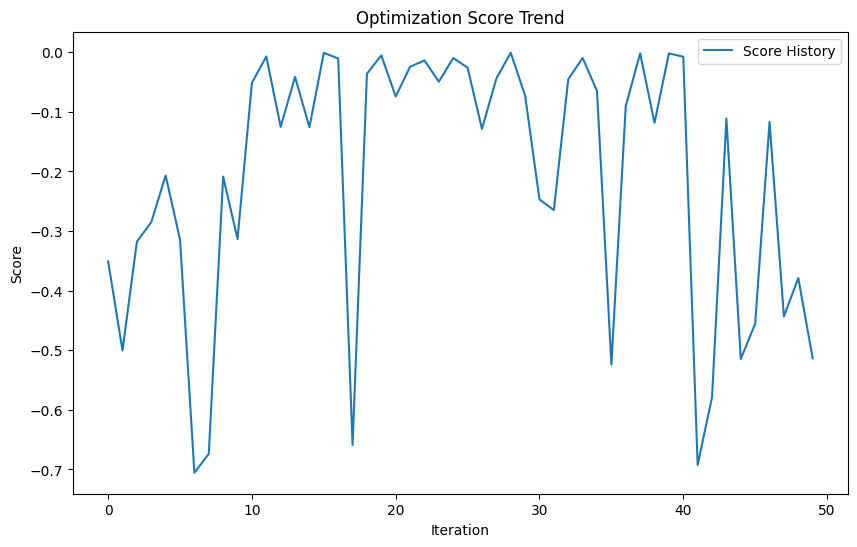

In [48]:
# Track scores for real-time visualization
score_history = []

optimizer = load_optimizer(kappa=2.5)
save_progress(optimizer)

# Run initial exploration
explorate(optimizer)

print("done with exploration")
# Run optimization
for i in range(40):
    optimize(optimizer)

# Output the best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best score:", optimizer.max["target"])

# Plot the optimization score trend
plot_scores()

In [38]:
def visualize_objective_surface_interactive(optimizer):
    # Use a 2D slice for simplicity (vary two parameters, fix others)
    x = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    y = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    X, Y = np.meshgrid(x, y)

    # Fixed parameters for visualization

    # Compute objective values for each combination of x, y
    Z = np.array([
        objective(xi, yi)
        for xi, yi in zip(np.ravel(X), np.ravel(Y))
    ])
    Z = Z.reshape(X.shape)

    # Extract evaluated points and hover information from optimizer.res
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []
    hover_texts = []

    for res in optimizer.res:
        params = res["params"]
        score = res["target"]

        evaluated_x.append(params["force2_start_time"])
        evaluated_y.append(params["force2_end_time"])
        evaluated_scores.append(score)

        # Format hover text to include all parameter values and the score
        hover_text = (
            f"<b>Score:</b> {score:.2f}<br>"
            f"<b>force2_start_time:</b> {params['force2_start_time']:.2f}<br>"
            f"<b>force2_end_time:</b> {params['force2_end_time']:.2f}"
        )
        hover_texts.append(hover_text)

    # Extract the best point
    best_params = optimizer.max["params"]
    best_x = best_params["force2_start_time"]
    best_y = best_params["force2_end_time"]
    best_score = optimizer.max["target"]

    # Create the interactive plot
    fig = go.Figure()

    # Add the contour surface
    fig.add_trace(go.Contour(
        x=x, y=y, z=Z,
        colorscale="Viridis",
        colorbar=dict(
            title="Score",
            titleside="right",
            x=1.12,  # Move colorbar slightly right
            len=0.8  # Adjust colorbar length
        ),
        contours=dict(showlabels=True),
        name="Objective Surface"
    ))

    # Add evaluated points with hover information
    fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Score",
                titleside="right",
                x=1.05,  # Move colorbar slightly right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add hover information
        hoverinfo="text",  # Display custom hover text
        name="Evaluated Points"
    ))

    # Add the best point
    fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the target point
    fig.add_trace(go.Scatter(
        x=[0.2], y=[0.7],
        mode='markers',
        marker=dict(
            size=15,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='gold')
        ),
        name=f"Target Value",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Update layout for better visualization
    fig.update_layout(
        title="Interactive Objective Function Surface",
        xaxis_title="force2_start_time",
        yaxis_title="force2_peak_time",
        xaxis=dict(scaleanchor="y"),  # Link x-axis scale to y-axis scale
        yaxis=dict(scaleanchor="x"),  # Link y-axis scale to x-axis scale
        legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.01),
        template="plotly"
    )

    # Show the interactive plot
    iplot(fig)


# Example usage:
visualize_objective_surface_interactive(optimizer)


In [40]:

def interactive_score_and_std_surface(optimizer, param_x, param_y, pbounds):
    # Fixed target values for other parameters
    force2_end_time_target = 0.7
    force2_start_time_target = 0.2

    # kappa = 2.5  # Exploration parameter for the acquisition function
    # acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    acquisition = bayes_opt.acquisition.ExpectedImprovement()

    # Generate a grid for two parameters
    x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
    y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
    scores = np.zeros((len(x_vals), len(y_vals)))
    stds = np.zeros((len(x_vals), len(y_vals)))

    # Populate grid with scores from the GP model
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            curr_score, curr_std = optimizer._gp.predict(
                [[y, x]], 
                return_std=True
            )
            scores[i, j] = curr_score.item()
            stds[i, j] = curr_std.item()

    xx, yy = np.meshgrid(x_vals, y_vals)
    grid_points = np.c_[xx.ravel(), yy.ravel()]  # Shape (n_samples, 2)

    acquisition_values = -1 * acquisition._get_acq(gp=optimizer._gp)(grid_points)
    acquisition_values = acquisition_values.reshape(xx.shape)

    # Extract evaluated points from optimizer
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []
    hover_texts = []

    for res in optimizer.res:
        params = res["params"]
        score = res["target"]

        evaluated_x.append(params[param_x])
        evaluated_y.append(params[param_y])
        evaluated_scores.append(score)

        # Format hover text to include all parameter values and the score
        hover_text = (
            f"<b>Score:</b> {score:.2f}<br>"
            f"<b>force2_start_time:</b> {params['force2_start_time']:.2f}<br>"
            f"<b>force2_end_time:</b> {params['force2_end_time']:.2f}"
        )
        hover_texts.append(hover_text)

    # Get the best point
    best_params = optimizer.max["params"]
    best_x = best_params[param_x]
    best_y = best_params[param_y]
    best_score = optimizer.max["target"]

    # Interactive score surface plot
    score_fig = go.Figure()

    # Add score surface
    score_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=scores.T,
        colorscale="Viridis",
        colorbar=dict(
            title="Score",
            titleside="right",
            x=1.0,  # Move colorbar slightly right
            len=0.8  # Adjust colorbar length
        ),
        contours=dict(showlabels=True),
        name="Score Surface"
    ))

    # Add evaluated points with hover information
    score_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=1.12,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add detailed hover information
        hoverinfo="text",
        name="Evaluated Points"
    ))

    # Add the best point (star)
    score_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    score_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_end_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_end_time_target}",
        hoverinfo="text"
    ))

    score_fig.update_layout(
        title="Interactive Score Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),  # Adjust legend position
        template="plotly"
    )

    iplot(score_fig)



    # Interactive standard deviation surface plot
    std_fig = go.Figure()

    # Add standard deviation surface
    std_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=stds.T,
        colorscale="Viridis",
        colorbar=dict(title="Standard Deviation"),
        contours=dict(showlabels=True),
        name="Standard Deviation Surface"
    ))

    # Add evaluated points
    std_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color="red",
            symbol="circle",
            line=dict(width=1, color="black")
        ),
        text=hover_texts,  # Reuse hover information with additional parameters
        hoverinfo="text",
        name="Evaluated Points"
    ))
    
    # Add the best point (star)
    std_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    std_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_end_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_end_time_target}",
        hoverinfo="text"
    ))

    std_fig.update_layout(
        title="Interactive Standard Deviation Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly"
    )

    iplot(std_fig)



    # Interactive acquisition function surface plot
    acq_fig = go.Figure()

    # Add acquisition function surface
    acq_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=acquisition_values.T,
        colorscale="Viridis",
        colorbar=dict(title="Acquisition Function"),
        contours=dict(showlabels=True),
        name="Acquisition Function Surface"
    ))

    # Add evaluated points
    acq_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color="red",
            symbol="circle",
            line=dict(width=1, color="black")
        ),
        text=hover_texts,  # Reuse hover information with additional parameters
        hoverinfo="text",
        name="Evaluated Points"
    ))

    # Add the best point (star)
    acq_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    acq_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_end_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_end_time_target}",
        hoverinfo="text"
    ))

    acq_fig.update_layout(
        title="Interactive Acquisition Function Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly"
    )

    iplot(acq_fig)

    # save the plot
    score_fig.write_html(f"/Users/nathanirniger/Desktop/plots/score_fig_{param_x}_{param_y}.html")
    std_fig.write_html(f"/Users/nathanirniger/Desktop/plots/std_fig_{param_x}_{param_y}.html")
    acq_fig.write_html(f"/Users/nathanirniger/Desktop/plots/acq_fig_{param_x}_{param_y}.html")




# Example usage:
interactive_score_and_std_surface(optimizer, 'force2_start_time', 'force2_end_time', pbounds)



TypeError: ExpectedImprovement.__init__() missing 1 required positional argument: 'xi'

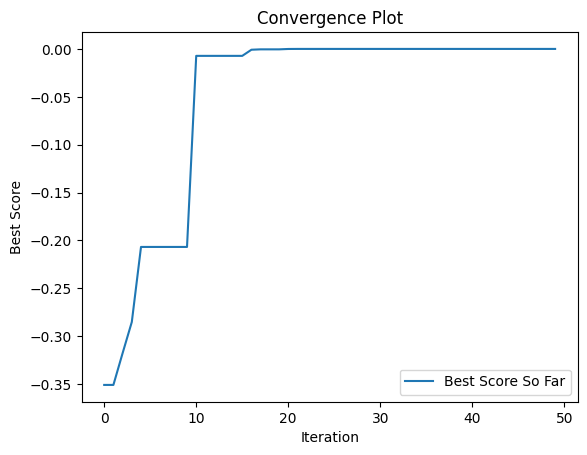

<Figure size 640x480 with 0 Axes>

In [21]:
best_scores = [max([res["target"] for res in optimizer.res[:i+1]]) for i in range(len(optimizer.res))]

plt.plot(best_scores, label='Best Score So Far')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('Convergence Plot')
plt.legend()
plt.show()
plt.savefig("/Users/nathanirniger/Desktop/plots/convergence_plot.png")


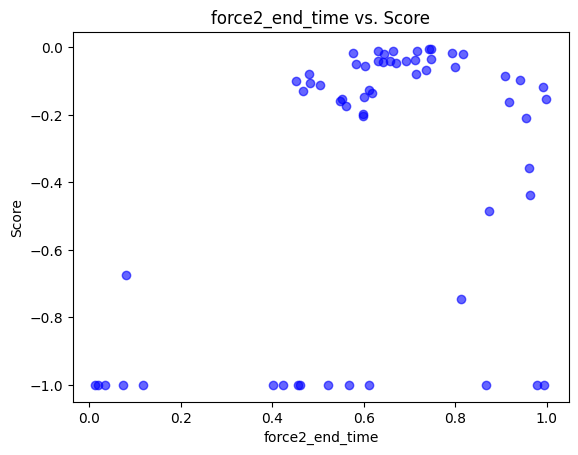

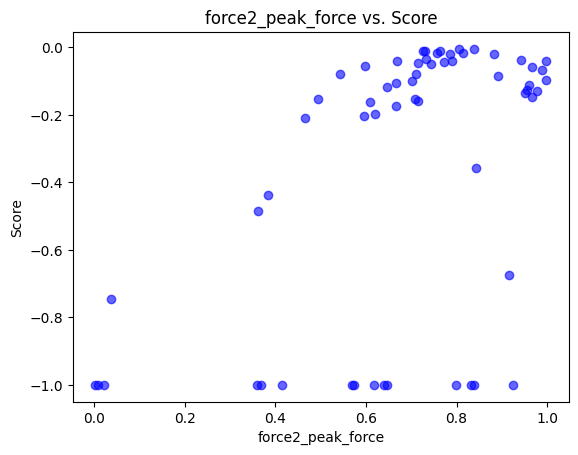

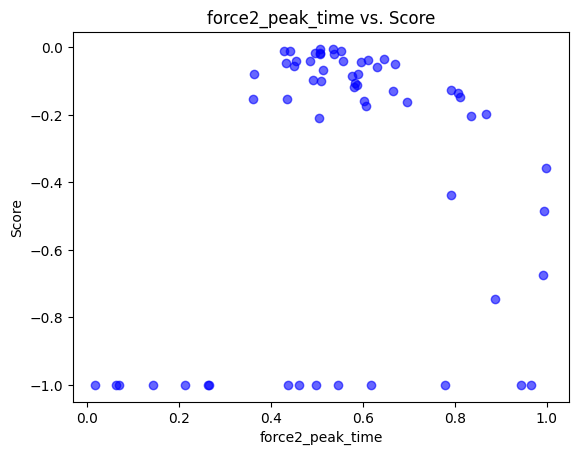

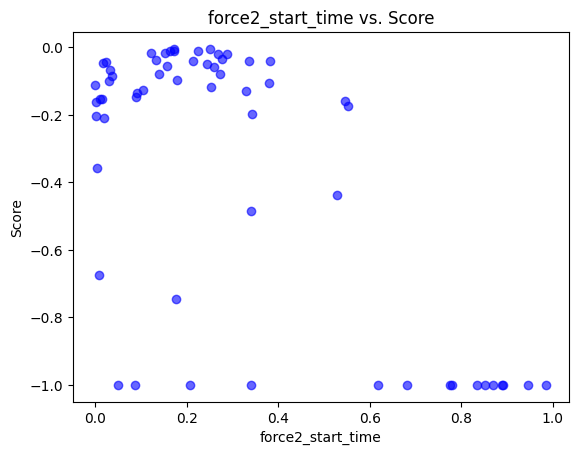

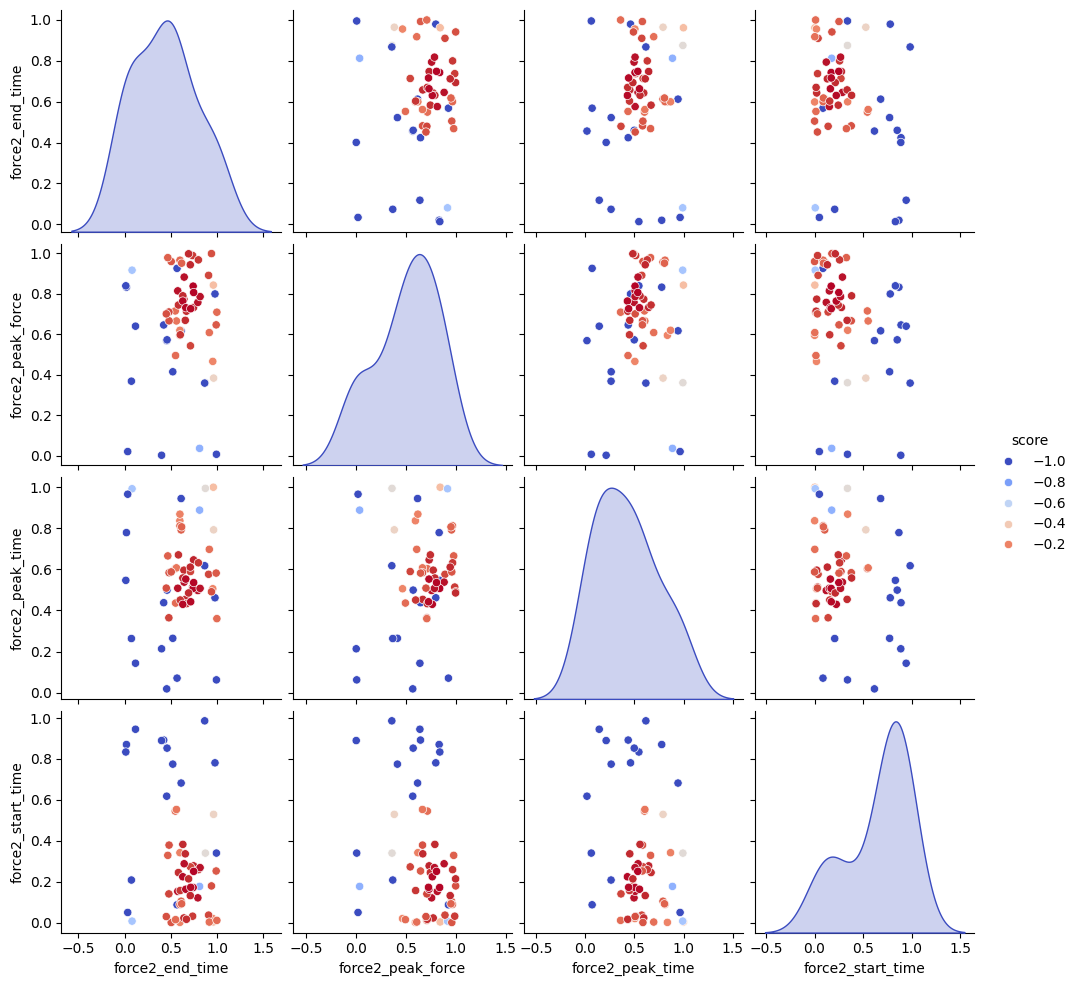

In [29]:
# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame([res['params'] | {'score': res['target']} for res in optimizer.res])

# 1D parameter vs. score plots
for param in results_df.columns[:-1]:  # Exclude score
    plt.figure()
    plt.scatter(results_df[param], results_df['score'], c='blue', alpha=0.6)
    plt.xlabel(param)
    plt.ylabel('Score')
    plt.title(f'{param} vs. Score')
    plt.show()

# 2D pair plots for selected parameters
sns.pairplot(results_df, vars=results_df.columns[:-1], hue='score', palette="coolwarm", diag_kind="kde")
plt.show()